In [2]:
import os 
import time
import copy
from tqdm import tqdm

import numpy as np 
import matplotlib.pyplot as plt
import scipy
import pandas as pd

from joblib import Parallel, delayed
from numba import jit, njit, prange

#################### Macros #############################
np.random.seed(0)

# Physical constants
K=12 # number of fermionic modes
J=4 # ~"energy scale"
Q=4 # order of coupling
N = 2*K # number of fermions
N_DIM = 2**K # Hilbert space dimensions

# Directory to save sample Hamiltonians
H_DIR = os.path.join("Simulated Hamiltonians", f"H4_K{K}_J{J}_Q{Q}")
os.makedirs(H_DIR, exist_ok=True)

N_SAMPLES = 160 # number of samples to generate
N_JOBS = 20 # number of jobs to run in parallel

################## Locals #############################
from hamiltonian_generation import make_H4_sparse

## 1. Define Hamiltonian

In [10]:
H4_func = make_H4_sparse(K, J, random_seed=0, precompute_pairs = True, precompute_quads = True)

# 2. Load pre-computed sample eigenvalues

See notebook: "computing_eigenvalues_for_unfolding.ipynb"

In [5]:
H_all= np.zeros((N_SAMPLES, N_DIM, N_DIM), dtype=np.complex128) 
iv_all = np.zeros((N_SAMPLES, N_DIM), dtype=np.float64) # iv = eigenvalues
for i in range(N_SAMPLES):
    H_all[i] = np.load(os.path.join(H_DIR, f"H4_{i+1}.npy"))
    iv_all[i] = np.linalg.eigvalsh(H_all[i])

MemoryError: Unable to allocate 20.0 GiB for an array with shape (160, 4096, 4096) and data type float64

In [6]:
np.save(os.path.join(H_DIR, "eigenvalues_all.npy"), iv_all)

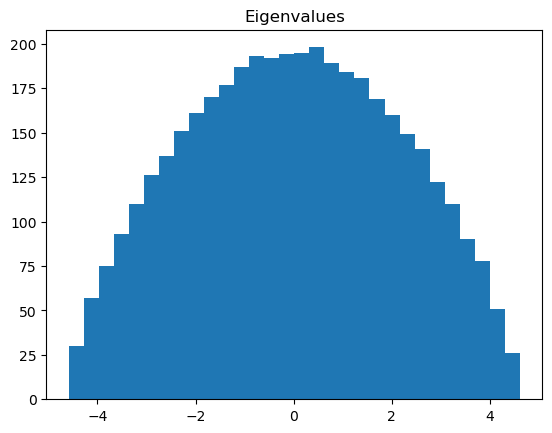

eigenvalues[test_i].nbytes: 32768


In [7]:
test_i = 12

plt.figure()
plt.hist(iv_all[test_i], bins=30)
plt.title("Eigenvalues")
plt.show()
plt.close()

print(f"eigenvalues[test_i].nbytes: {iv_all[test_i].nbytes}")

## 4. Define unfolding function

In [8]:
def unfold(iv):
    iv = np.sort(iv)
    iv_unfolded = np.zeros(iv.shape, dtype=np.float64)

    for i, e in enumerate(iv):
        # Find the mean number of eigenvalues lower than e
        for j in range(iv_all.shape[0]):
            iv_j = iv_all[j]
            iv_unfolded[i] += np.sum(iv_j < e) 

    iv_unfolded /= iv_all.shape[0]

    return iv_unfolded

### 4.a. Try it out on test Hamiltonian

In [11]:
sigma_j = np.sqrt((J**2)*np.math.factorial(Q-1)/(N**(Q-1)))
js_test = np.random.normal(0, sigma_j, size=tuple([N for i in range(Q)]))

H4_test = H4_func(js_test).toarray()
iv_test = np.linalg.eigvals(H4_test)
iv_test_unfolded = unfold(iv_test)

plt.figure()
plt.hist(iv_test, bins=30)
plt.title("Eigenvalues")
plt.show()
plt.close()

plt.figure()
plt.hist(iv_test_unfolded, bins=30)
plt.title("Unfolded eigenvalues")
plt.show()
plt.close()

LinAlgError: 0-dimensional array given. Array must be at least two-dimensional

### 4.b. Try it on several of the precomputed sample Hamiltonians

Yes, yes, it's improper to do this considering these samples constitute the mean from which the unfolding function is defined in the first place. But I think we have a large-enough sample size to get away with this. 

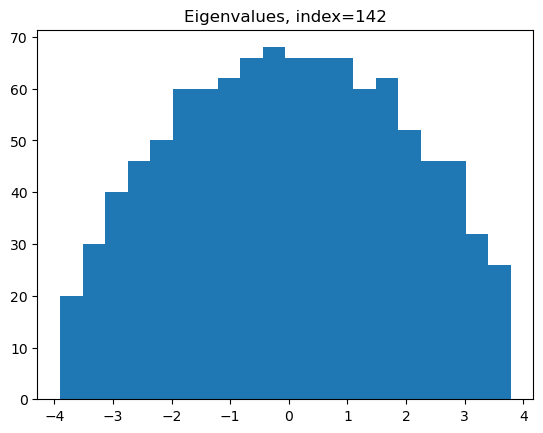

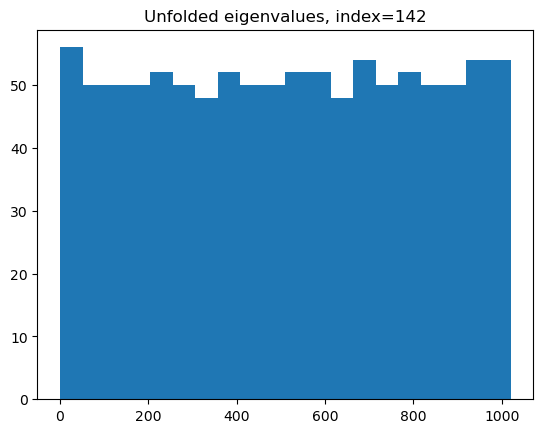

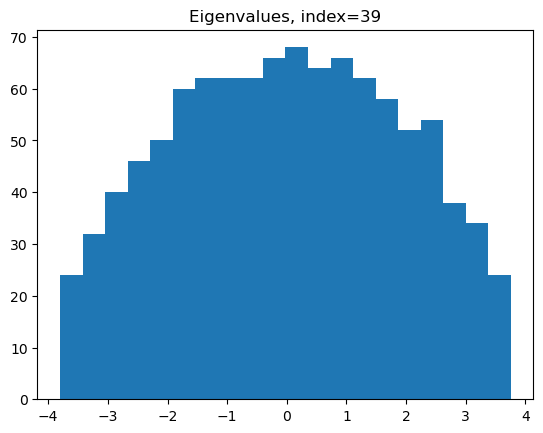

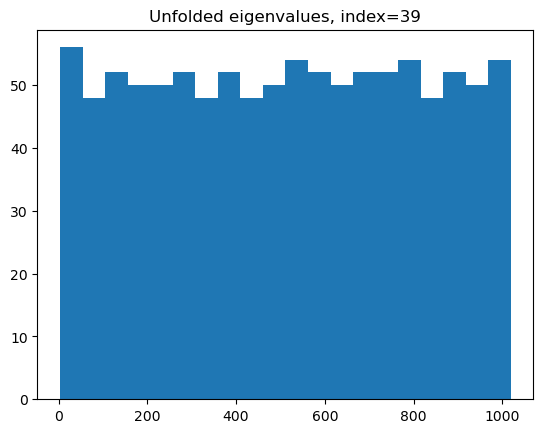

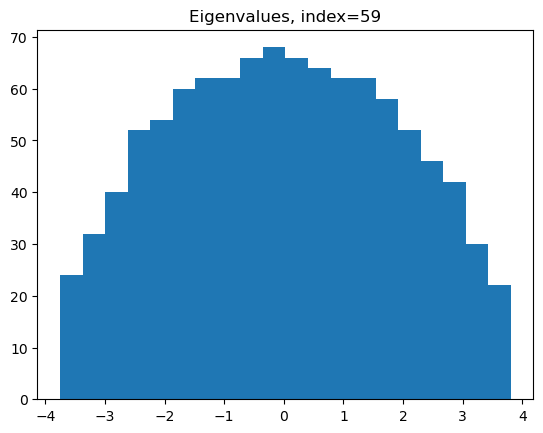

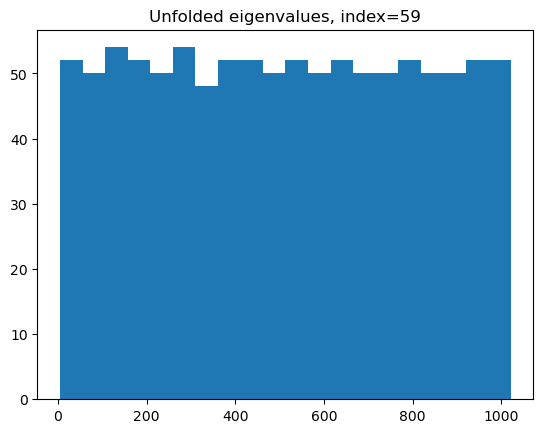

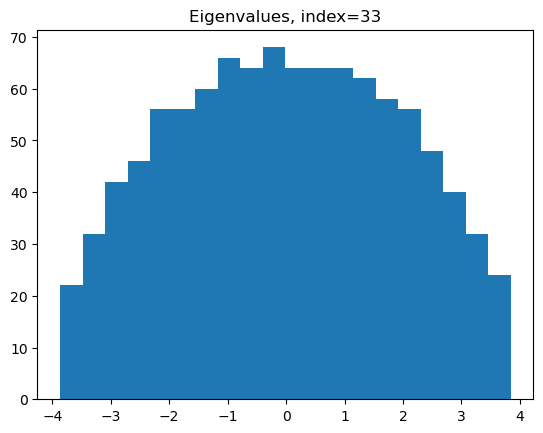

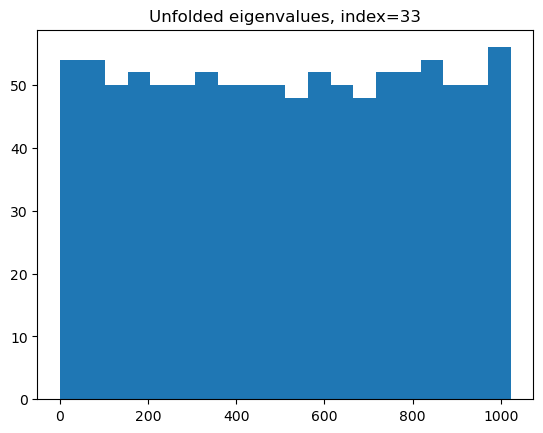

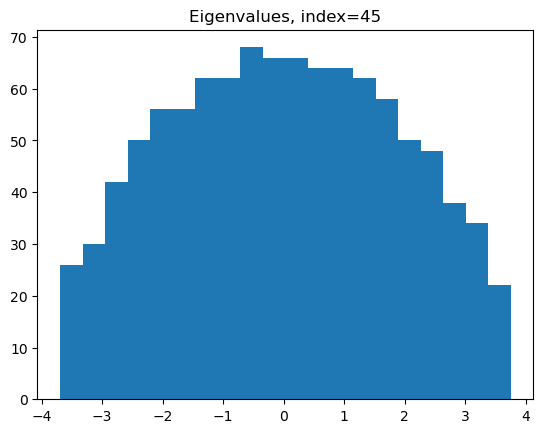

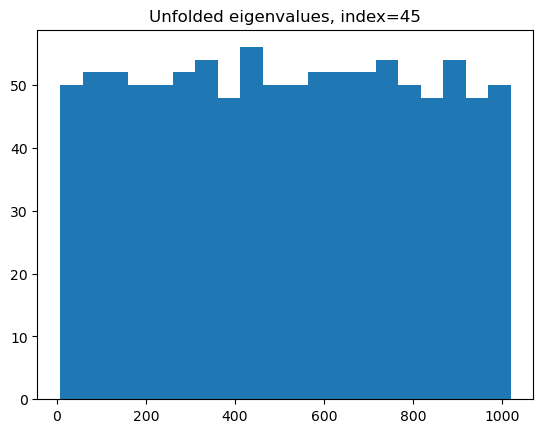

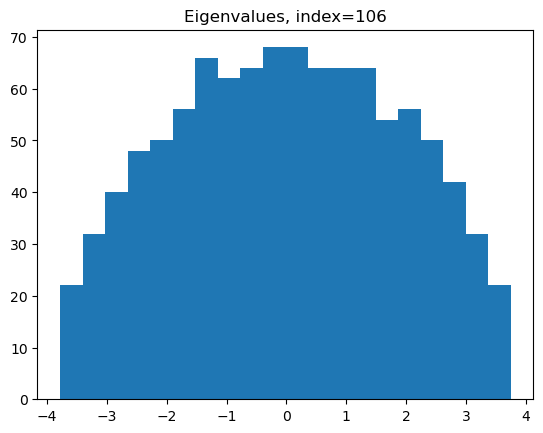

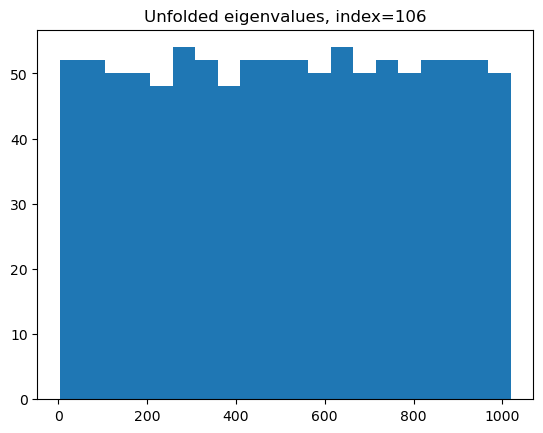

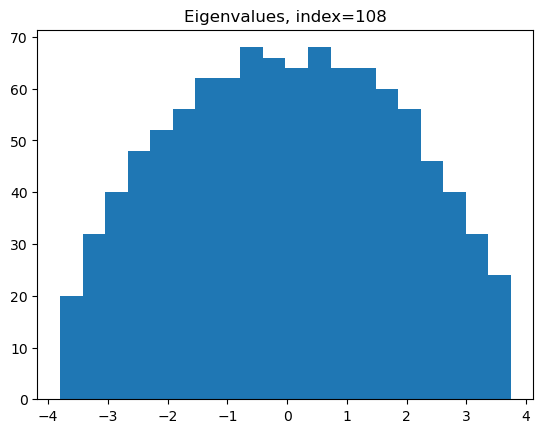

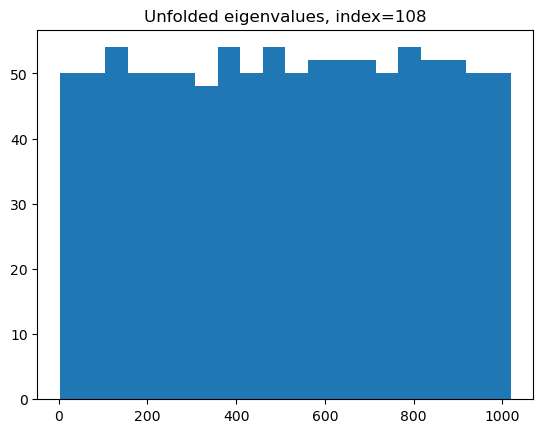

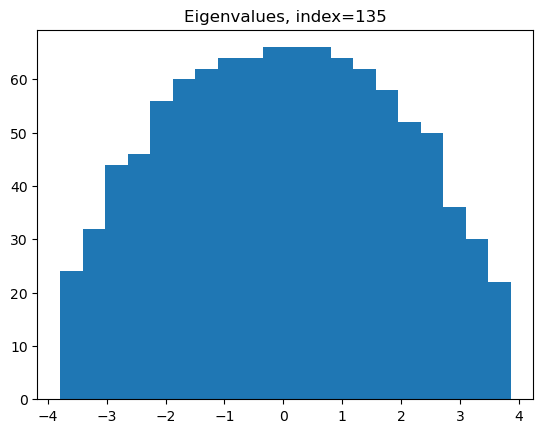

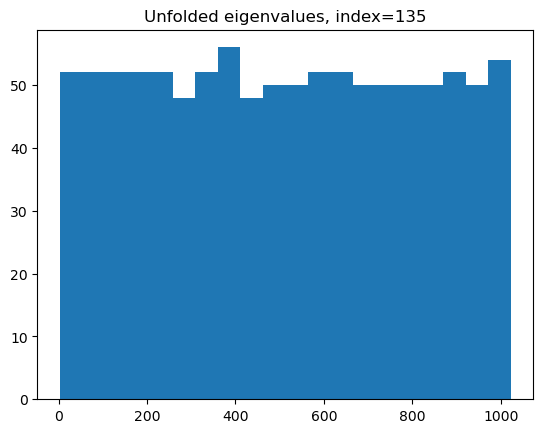

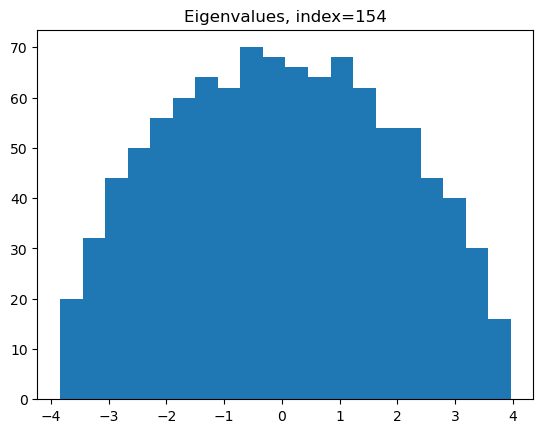

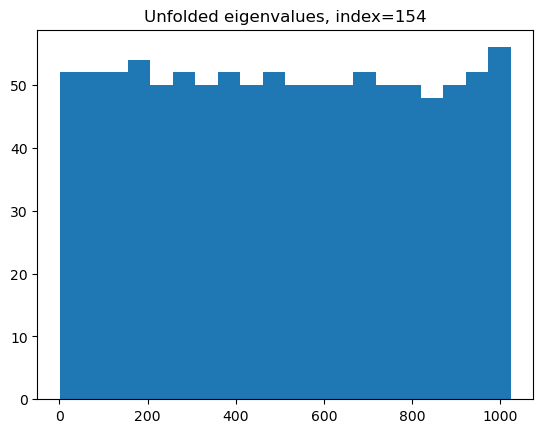

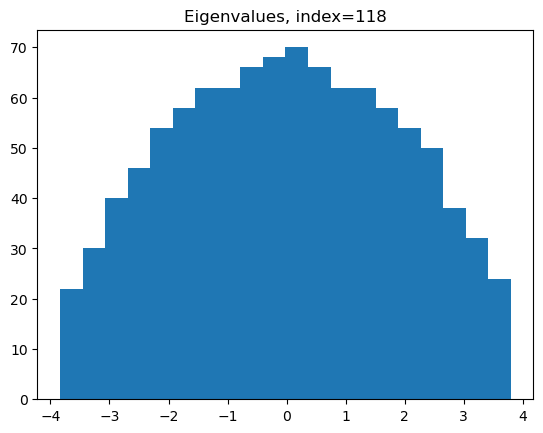

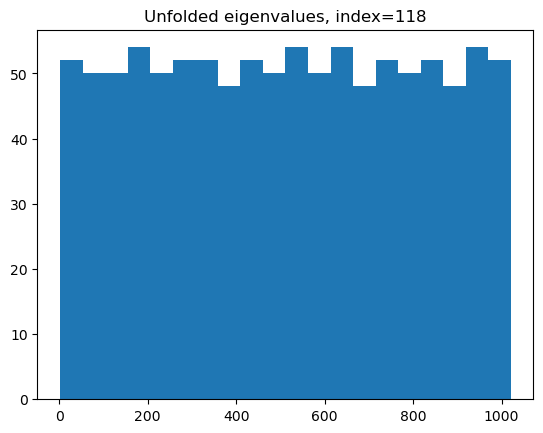

In [18]:
for i in range(10):
    index = np.random.choice(iv_all.shape[0])
    iv_i = iv_all[index]
    iv_unfolded_i = unfold(iv_i)

    plt.figure()
    plt.hist(iv_i, bins=30)
    plt.title(f"Eigenvalues, index={index}")
    plt.show()
    plt.close()

    plt.figure()
    plt.hist(iv_unfolded_i, bins=30)
    plt.title(f"Unfolded eigenvalues, index={index}")
    plt.show()

### 4. c Check out the mean eigenvalues, unfolded mean eigenvalues

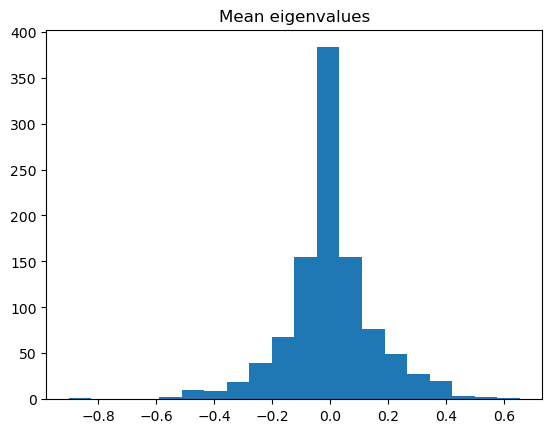

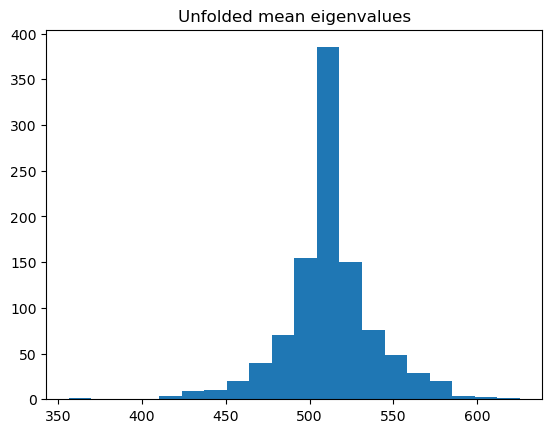

In [19]:
iv_mean = np.mean(iv_all, axis=0)
plt.figure()
plt.hist(iv_mean, bins=30)
plt.title("Mean eigenvalues")
plt.show()
plt.close()

iv_mean_unfolded = unfold(iv_mean)
plt.figure()
plt.hist(iv_mean_unfolded, bins=30)
plt.title("Unfolded mean eigenvalues")
plt.show()
plt.close()

### 4.d. Check out the $\textit{mean unfolded}$ eigenvalues, not to be confused with the unfolded mean eigenvalues

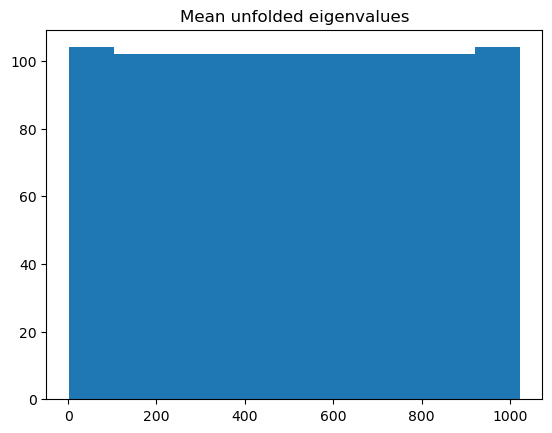

In [20]:
iv_unfolded_all = np.zeros(iv_all.shape, dtype=np.float64)
for i in range(iv_all.shape[0]):
    iv_unfolded_all[i] = unfold(iv_all[i])

iv_unfolded_mean = np.mean(iv_unfolded_all, axis=0)
plt.figure()
plt.hist(iv_unfolded_mean, bins=10)
plt.title("Mean unfolded eigenvalues")
plt.show()
plt.close()

### 4.e. Check out how big one of these Hamiltonians/eigenvalues is

In [21]:
print(f"H4_matrix_test.nbytes: {H4_test.nbytes}")
print(f"H4_iv_test.nbytes: {iv_test.nbytes}")

H4_matrix_test.nbytes: 16777216
H4_eigvals_test.nbytes: 16384
